In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import rc
from load_data import load_data

In [ ]:
case_name = 'laminar'

gt_ten = load_data(case_name)
gt_ten = torch.from_numpy(gt_ten).type(torch.float32)

pred_ten = torch.load(f'{case_name}_predicted_ten.pt')

print(gt_ten.shape)
print(pred_ten.shape)


Loading Data: DONE



torch.Size([3, 100, 40, 64, 499])
torch.Size([3, 100, 40, 64, 500])


In [3]:
gt_mat = gt_ten.reshape((-1, gt_ten.shape[-1]))

mean_flow = gt_mat.mean(dim = -1, keepdim = True)

U, S, VT = torch.linalg.svd(gt_mat - mean_flow, full_matrices = False)

recon = U[:,:10] @ S[:10].diag() @ VT[:10, :]

recon += mean_flow

recon = recon.reshape(gt_ten.shape)

In [4]:
gt_mat = gt_ten.reshape((-1, gt_ten.shape[-1]))
gt_mat = gt_mat[..., :100]

mean_flow = gt_mat.mean(dim = -1, keepdim = True)

U, S, VT = torch.linalg.svd(gt_mat - mean_flow, full_matrices = False)

recon = U[:,:10] @ S[:10].diag() @ VT[:10, :]

recon += mean_flow

recon = recon.reshape([*gt_ten.shape[:-1], 100])

In [5]:
_ = torch.cumsum(S, dim = 0)

([<matplotlib.axis.YTick at 0x7f20714d8a90>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

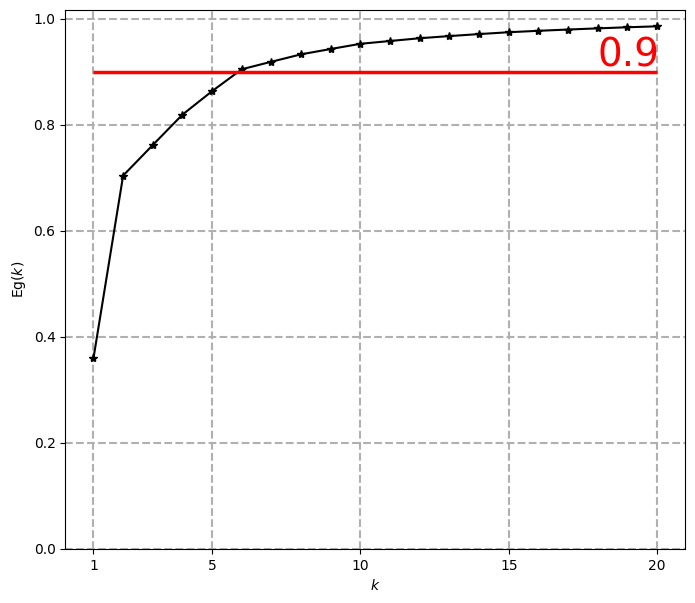

In [6]:
fig = plt.figure(figsize = (8,7))
plt.plot(np.arange(1,21),_[:20] / _[-1], '-*', color = 'k', linewidth = 1.5)
plt.hlines([0.9], xmin = [1.], xmax = [20.], color = "r", linewidth = 2.5)
plt.grid(True, linewidth = 1.5, linestyle = "--")
plt.text(18, 0.91, "0.9", fontsize = 28, color = "r")
plt.ylabel("Eg($k$)")
plt.xlabel("$k$")
plt.xticks([1, 5, 10, 15, 20])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

In [7]:
def vorticity(velocity, dx = 1, dy = 1):

    # Extract u and v components
    u = velocity[0, ...]  # u (x-component of velocity) shape: [100, 40, 200]
    v = velocity[1, ...]  # v (y-component of velocity) shape: [100, 40, 200]

    # Compute partial derivatives using finite differences
    # Derivative of v with respect to x (axis=0 corresponds to x-dimension)
    dvdx = (v[2:, :, :] - v[:-2, :, :]) / dx**2

    dvdx = torch.cat((torch.zeros(1, v.shape[1], v.shape[2]), dvdx), dim=0)
    dvdx = torch.cat((dvdx, torch.zeros(1, v.shape[1], v.shape[2])), dim=0)  # Pad to maintain shape

    # Derivative of u with respect to y (axis=1 corresponds to y-dimension)
    dudy = (u[:, 2:, :] - u[:, :-2, :]) / dy**2
    dudy = torch.cat((torch.zeros(u.shape[0], 1, u.shape[2]), dudy), dim=1)
    dudy = torch.cat((dudy, torch.zeros(u.shape[0], 1, u.shape[2])), dim=1)  # Pad to maintain shape

    # Compute vorticity: omega = dv/dx - du/dy
    vorticity = dvdx - dudy  # Shape: [100, 40, 200]

    vorticity = vorticity.permute((1,0,2))

    return vorticity

In [8]:
dx = (50) / gt_ten.shape[1]
dy = (12) / gt_ten.shape[2]

vor_pred = torch.vmap(vorticity, in_dims = 3)(pred_ten, dx = dx, dy = dy)
vor_recon = torch.vmap(vorticity, in_dims = 3)(gt_ten, dx = dx, dy = dy)

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 24,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'text.latex.preamble': r'\usepackage{amsmath}'
})

rc('text', usetex=True)

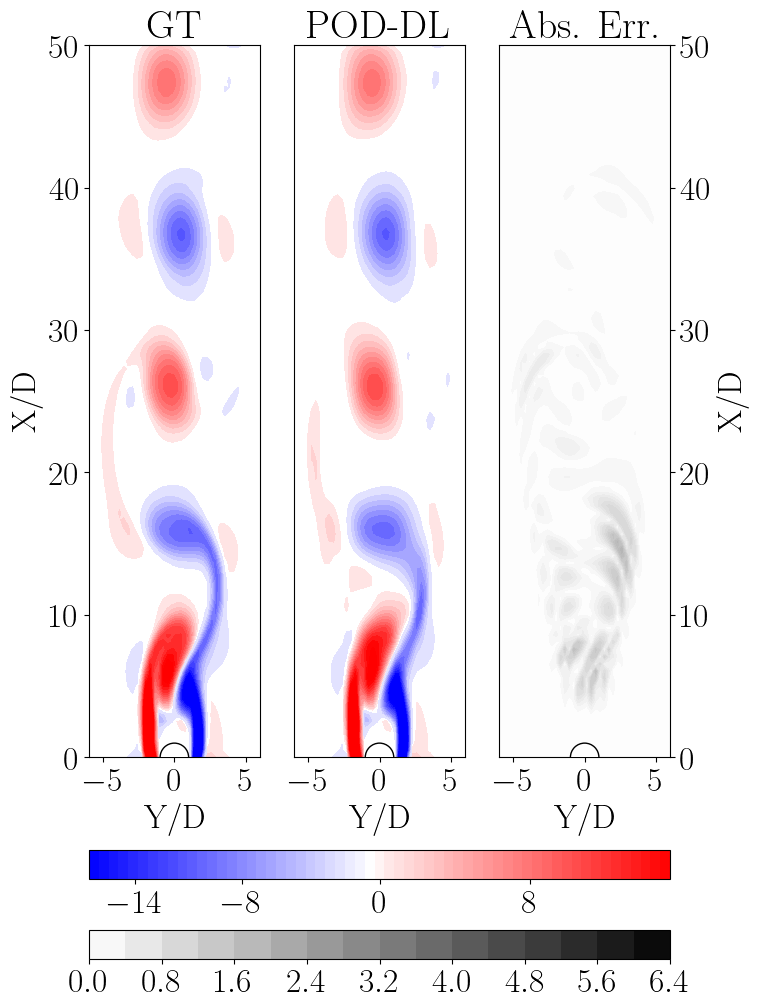

In [10]:
plt.close('all')
plt.rcParams.update({
    "font.size": 24
})

fig, axs = plt.subplots(1, 3, figsize = (7.5, 12))

# snap = indices[90]
snap = 150
# snap = 480

vmin = vor_recon[32, :, :, snap].min()
vmax = vor_recon[32, :, :, snap].max()

# vmin = -7
# vmax = 7

levels_1 = np.linspace(0.5, vmax, 30)
levels_2 = np.linspace(vmin, -0.5, 30)

levels = np.concatenate((levels_2, levels_1))

x = np.linspace(0, 50, vor_recon.shape[2])
y = np.linspace(-6, 6, vor_recon.shape[1])

im = axs[0].contourf(x, y, vor_recon[32,:,:,snap], levels, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[0].clear()
vmin = -7
vmax = 7
axs[0].contourf(y, x, vor_recon[32,:,:,snap].T, levels_1, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[0].contourf(y, x, vor_recon[32,:,:,snap].T, levels_2, vmin = vmin, vmax = vmax, cmap = "bwr")
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', zorder=10)
axs[0].add_artist(circle)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title("GT")
axs[0].set_xlabel("Y/D")
axs[0].set_ylabel("X/D")

# im = plt.contourf(x, y, vor_recon[32,:,:,10], 12, vmin = vmin, vmax = vmax, cmap = "bwr")

axs[1].contourf(y, x, vor_pred[32,:,:,snap].T, levels_1, vmin = vmin, vmax = vmax, cmap = "bwr")
axs[1].contourf(y, x, vor_pred[32,:,:,snap].T, levels_2, vmin = vmin, vmax = vmax, cmap = "bwr")
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', zorder=10)
axs[1].add_artist(circle)
axs[1].set_aspect('equal', adjustable='box')
axs[1].tick_params(
    left = False, 
    right = False, 
    labelleft = False, 
    labelright = False,
    labelbottom = True, 
    bottom = True
)
axs[1].set_title("POD-DL")
axs[1].set_xlabel("Y/D")

diff = torch.load("diff_cil_3.pt")
im2 = axs[2].contourf(x, y, diff, 15, vmin = 0, vmax = 6.5, cmap = "gray_r")
axs[2].clear()
diff = (vor_recon[32,:,:,snap] - vor_pred[32,:,:,snap]).abs()
axs[2].contourf(y, x, diff.T, 15, vmin = 0, vmax = 6.5, cmap = "gray_r")
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', zorder=10)
axs[2].add_artist(circle)
axs[2].set_aspect('equal', adjustable='box')
axs[2].tick_params(
    left = False, 
    right = True, 
    labelleft = False, 
    labelright = True,
    labelbottom = True, 
    bottom = True
)
axs[2].yaxis.set_label_position('right')
axs[2].set_title("Abs. Err.")
axs[2].set_xlabel("Y/D")
axs[2].set_ylabel("X/D")

fig.colorbar(im2, ax = axs[0:], fraction = 0.04, pad = 0.05, location = 'bottom')
cbar = fig.colorbar(im, ax = axs[0:], ticks = [-14, -8, 0, 8, 17], fraction = 0.04, pad = 0.11, location = 'bottom')
# cbar.locator = MaxNLocator(nbins = 5)
# cbar.update_ticks()

# Metric 1: Quantiles

In [11]:
_ = vor_recon.reshape((-1, 499))

gt_median = torch.quantile(_, 0.5, dim = 0)
gt_25th = torch.quantile(_, 0.25, dim = 0)
gt_75th = torch.quantile(_, 0.75, dim = 0)

_ = vor_pred[..., :499].reshape((-1, 499))

pred_median = torch.quantile(_, 0.5, dim = 0)
pred_25th = torch.quantile(_, 0.25, dim = 0)
pred_75th = torch.quantile(_, 0.75, dim = 0)

del _

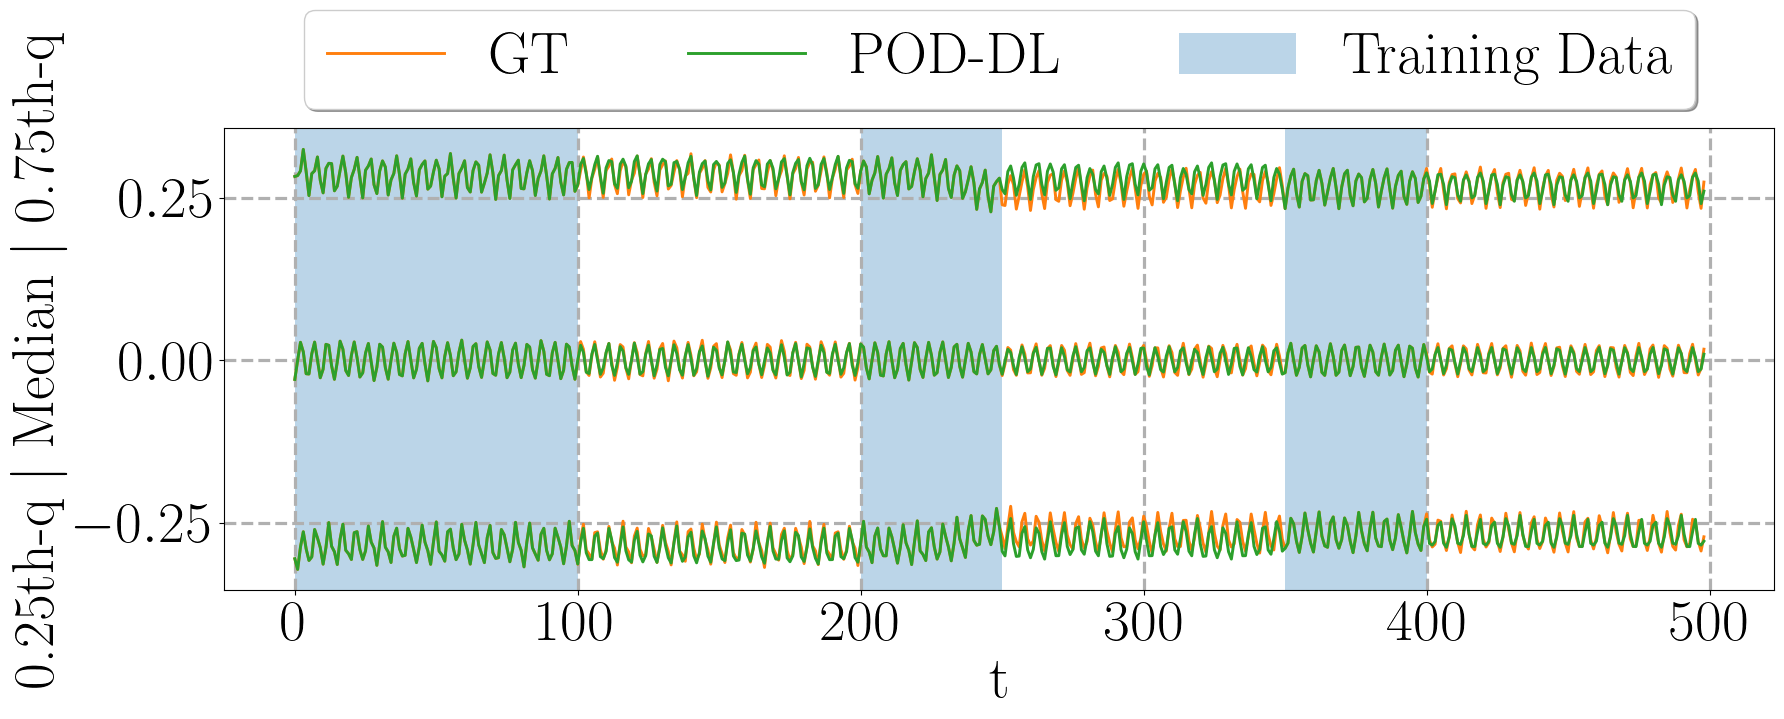

In [12]:
plt.rcParams.update({
    "font.size": 42
})

rc('text', usetex=True)

plt.close('all')
plt.figure(figsize = (20, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(gt_median, c = colors[1], linewidth = 2.1, label = "GT")
plt.plot(pred_median, c = colors[2], linewidth = 2.1, label = "POD-DL")

plt.plot(gt_75th, '-', c = colors[1], linewidth = 2.1)
plt.plot(pred_75th, '-', c = colors[2], linewidth = 2.1)

plt.plot(gt_25th, '-', c = colors[1], linewidth = 2.1)
plt.plot(pred_25th, '-', c = colors[2], linewidth = 2.1)

plt.grid(True, linestyle = '--', linewidth = 2.3)
# plt.xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
# plt.yticks([4.455, 4.4575, 4.460, 4.4625, 4.465])

# # S0=100, S1=100, P=400
# plt.axvspan(0, 100, alpha=0.3, label = "Training Data")

# # S0=100, S1=100, P=100
# plt.axvspan(0, 100, alpha=0.3, label = "Training Data")
# plt.axvspan(200, 300, alpha=0.3)

# S0=100, S1=50, P=100
plt.axvspan(0, 100, alpha=0.3, label = "Training Data")
plt.axvspan(200, 250, alpha=0.3)
plt.axvspan(350, 400, alpha=0.3)

plt.xlabel("t")#, fontsize = 25)
plt.ylabel("0.25th-q $|$ Median $|$ 0.75th-q")#, fontsize = 25)

plt.legend(loc='upper center', bbox_to_anchor = (0.5, 1.32), ncol = 3, fancybox = True, shadow = True)

# Metric 2: Error Prob.

In [13]:
def compute_hist_mae(err_val, bin_width, gt_ten, pred_ten):

    diff_1 = torch.abs(gt_ten - pred_ten)
    
    if (diff_1.max().abs() <= 1e-8):

        return 1.

    else:
        bin_edges_1 = torch.arange(0.0, diff_1.max() + bin_width, bin_width)

        p_hist_1, _ = torch.histogram(diff_1, bins = bin_edges_1, density = True)

        # bin_width = bin_edges[1] - bin_edges[0]

        p_1 = p_hist_1 * bin_width

        # prob_val = torch.where(bin_edges <= err_val)[0][-1]
        prob_val = int(err_val // bin_width)

        return p_1[:prob_val].sum()

In [14]:
diff_p1 = torch.zeros(vor_recon.shape[-1])
diff_p2 = torch.zeros(vor_recon.shape[-1])

err_val_1 = 0.5
err_val_2 = 1

for i1 in range(vor_recon.shape[-1]):

    diff_p1[i1] = compute_hist_mae(
        err_val_1,
        0.05,
        vor_recon[..., i1].flatten(), 
        vor_pred[..., i1].flatten(),
    )

    diff_p2[i1] = compute_hist_mae(
        err_val_2,
        0.05,
        vor_recon[..., i1].flatten(), 
        vor_pred[..., i1].flatten(),
    )

# diff_p1 = torch.nan_to_num(diff_p1, 1.0)

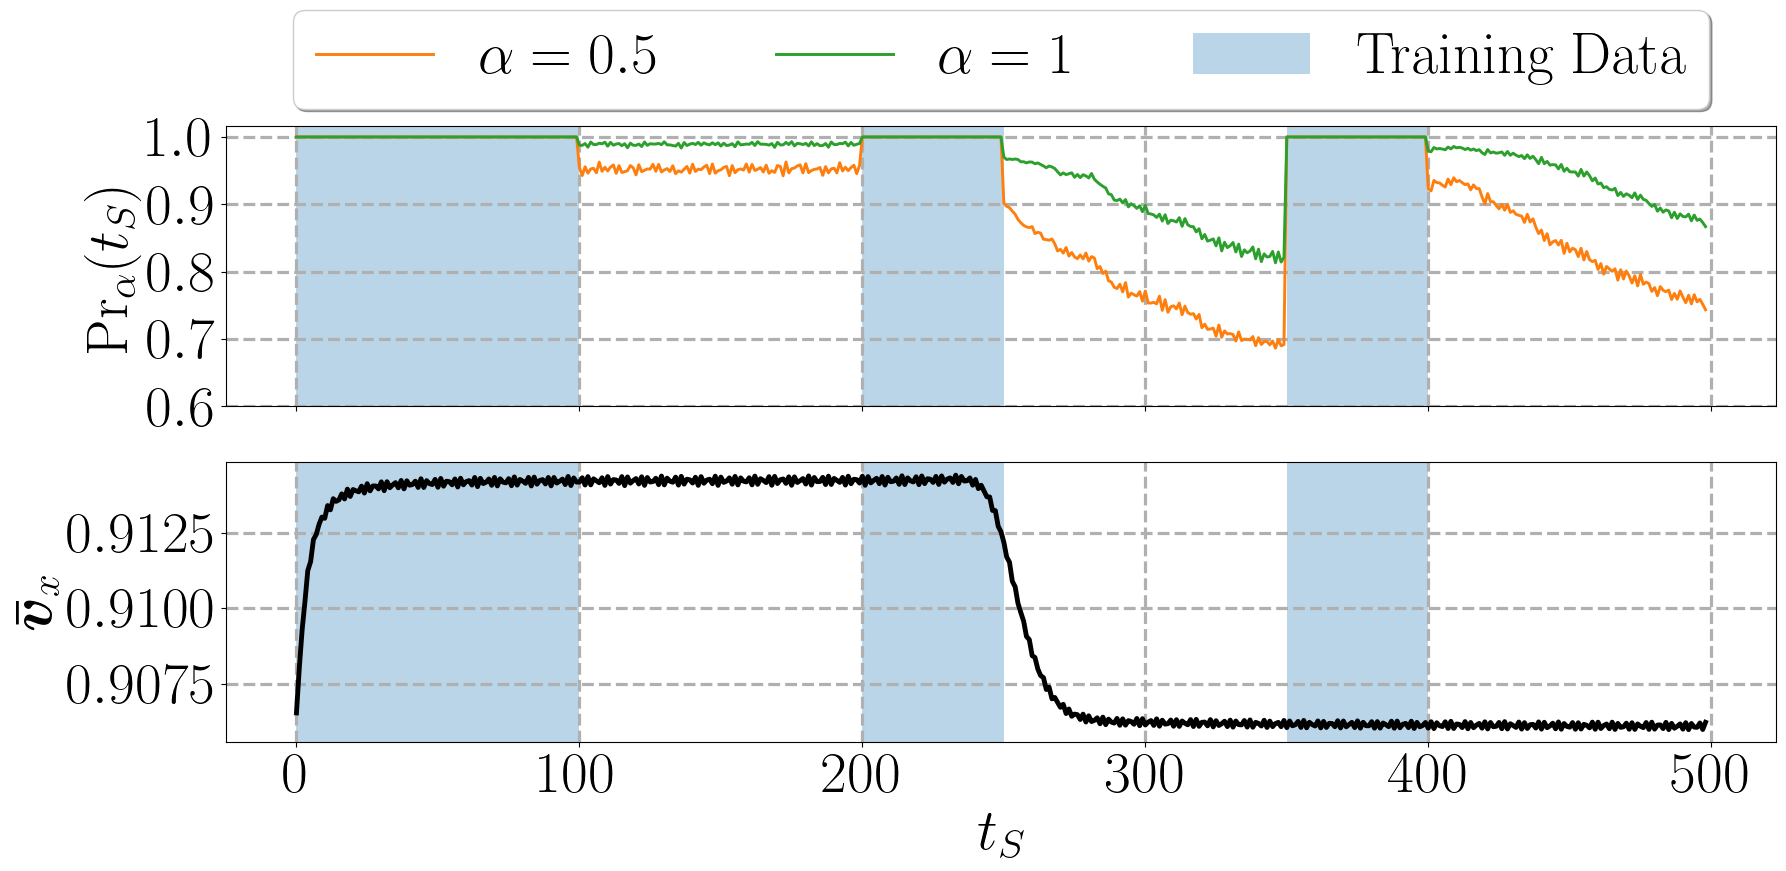

In [15]:
plt.rcParams.update({
    "font.size": 42
})

plt.close('all')

mean_vor = gt_ten[0,...].mean(dim = (0,1,2))

fig, axs = plt.subplots(2, 1, figsize = (20, 8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(diff_p1, linewidth = 2.1, label = rf'$\alpha = {err_val_1}$', c = colors[1])
axs[0].plot(diff_p2, linewidth = 2.1, label = rf'$\alpha = {err_val_2}$', c = colors[2])

axs[0].grid(True, linestyle = '--', linewidth = 2.3)
axs[0].set_xticks([0, 100, 200, 300, 400, 500])
axs[0].set_yticks([0.60, 0.7, 0.8, 0.9, 1])
axs[0].set_xticklabels([])

axs[1].plot(mean_vor, "k", linewidth = 3.5)
axs[1].grid(True, linestyle = '--', linewidth = 2.3)
axs[1].set_xticks([0, 100, 200, 300, 400, 500])
axs[1].set_ylabel(r"$\boldsymbol{\bar{v}}_{x}$")
axs[1].set_xlabel(r"$t_{S}$")

# # S0=100, S1=100, P=400
# axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
# axs[1].axvspan(0, 100, alpha=0.3)

# # S0=100, S1=100, P=400
# axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
# axs[0].axvspan(200, 300, alpha=0.3)
# axs[1].axvspan(0, 100, alpha=0.3)
# axs[1].axvspan(200, 300, alpha=0.3)

# S0=100, S1=50, P=100
axs[0].axvspan(0, 100, alpha=0.3, label = "Training Data")
axs[0].axvspan(200, 250, alpha=0.3)
axs[0].axvspan(350, 400, alpha=0.3)
axs[1].axvspan(0, 100, alpha=0.3)
axs[1].axvspan(200, 250, alpha=0.3)
axs[1].axvspan(350, 400, alpha=0.3)

axs[1].set_xlabel(r"$t_{S}$")
axs[0].set_ylabel(r"$\text{Pr}_{\alpha}(t_{S})$")

axs[0].legend(loc='upper center', bbox_to_anchor = (0.5, 1.52), ncol = 4, fancybox = True, shadow = True)